# How to infer a complete landscape from experimental data

In contrast to theoretical or toy landscapes, empirical landscapes that are based on experimental data. Such data is noisy and incomplete, so we need to apply additional methods before we have estimates for every genotype of interest to visualize the structure of the genotype-phenotype map.


## Introduction to Variance Component regression

We provide a simple interface to perform Variance Component regression. Briefly, VC regression uses the empirical data to estimate a prior distribution to perform Gaussian Process regression on functions over sequence space characterized by the contribution of the different orders of interaction to the sequence-dependent variability in the data.

A function $f$ can be decomposed into pure $k$th order functions over sequence space for sequences of length $\ell$

$$f = \sum_{k=0}^{\ell} f_k$$

Then, we can estimate and predict the phenotype at every possible sequence assuming that the prior is still valid in regions of sequence space or genotypes that have not been experimentally measured


For more detailed explanations we refer to the original paper

- Zhou, J.; Wong, M. S.; Chen, W.; Krainer, A. R.; Justin, B.; Mccandlish, D. M. Higher-Order Epistasis and Phenotypic Prediction. Proc. Natl. Acad. Sci. USA 2022, 119 (39). [https://doi.org/10.1073/pnas.2204233119](https://doi.org/10.1073/pnas.2204233119).



In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import holoviews as hv
import matplotlib.pyplot as plt
import gpmap.src.plot as plot

from os.path import join
from scipy.stats import pearsonr
from gpmap.src.datasets import DataSet
from gpmap.src.inference import VCregression

## Inference from simulated data

We first illustrate how to run VC regression on simulated data from the prior distribution characterized by the variance components $\lambda$'s of each order of interaction. 

### How to sample functions from the prior distribution

A simple way to sample from the prior distribution is by sampling a random uncorrelated function $a$

$$a \sim Normal(0, 1)$$

project it into the different subspaces using the projection operator $W_k$, rescale them to have the associated variance and add them up together

$$f = \sum_{k=0}^{\ell}\lambda_k^{\frac{1}{2}}W_k a$$

We can do it simply as follows, adding some random noise and missing data points for which we can make predictions later

In [2]:
np.random.seed(0)
lambdas_true = np.array([0, 1e3, 2e2, 1e0, 1e-1, 3e-3, 1e-5])

model = VCregression()
model.init(seq_length=6, alphabet_type='dna')
data = model.simulate(lambdas_true, sigma=0.2, p_missing=0.1)
obs = data.dropna()
obs

,y_true,y,y_var
AAAAAA,-0.207772,0.118123,0.04
AAAAAC,-1.686822,-1.706631,0.04
AAAAAT,2.064266,1.774501,0.04
AAAACA,1.263788,0.920955,0.04
AAAACC,0.818644,0.808716,0.04
...,...,...,...
TTTTGG,-1.030013,-0.713674,0.04
TTTTGT,2.345377,2.364254,0.04
TTTTTC,-1.461869,-1.328660,0.04
TTTTTG,-2.741072,-2.634664,0.04


### How to estimate Variance Components $\lambda$'s

This is done through kernel alignment, this is, matching the raw second order matrix with a non-negative linear combination of the covariance matrices associated to each pure $k$ order component 

$$K_{BB} = D_{var} + \sum_k \lambda_k K_k$$

by finding the $\lambda$'s that minimize the Frobenius norm of the difference

$$\min_{\lambda} \lVert yy^T - K_{BB}\lVert_F^2$$




In [3]:
lambdas = model.fit(X=obs.index.values, y=obs.y.values, y_var=obs.y_var.values)
vc = model.lambdas_to_variance(lambdas)
vc_p = vc / vc.sum() * 100

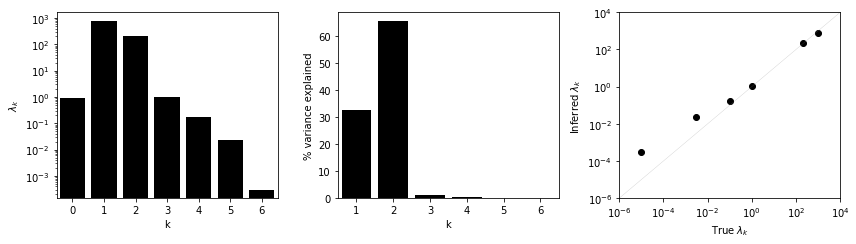

In [4]:
k = np.arange(lambdas.shape[0])

fig, subplots = plt.subplots(1, 3, figsize=(12, 3.5))

axes = subplots[0]
sns.barplot(x=k, y=lambdas, ax=axes, color='black')
axes.set(xlabel='k', ylabel=r'$\lambda_k$', yscale='log')

axes = subplots[1]
sns.barplot(x=k[1:], y=vc_p, ax=axes, color='black')
axes.set(xlabel='k', ylabel='% variance explained')

axes = subplots[2]
axes.scatter(lambdas_true, lambdas, c='black')
lims = (1e-6, 1e4)
axes.plot(lims, lims, c='grey', lw=0.3, alpha=0.5)
axes.set(xscale='log', yscale='log',
         xlabel=r'True $\lambda_k$',
         ylabel=r'Inferred $\lambda_k$',
         xlim=lims, ylim=lims)

fig.tight_layout()

We can see that the inferred variance components are very similar in log scale to the true data-generating parameters. 

However, when data is sparse, kernel alignment is a hard problem and we need to regularize towards simpler solutions. While we could shrink towards additivity, another good general choice that still models high order interactions is towards exponential decay of the variance components. We can do it by setting `cross_validation=True` and penalizing the second order moments of the $\log \lambda_k$ as a function of $k$. It will automatically split the data into different folds and perform kernel alignment under different regularization strength to find the penalization constant that minimizes the Frobenius norm in the validation sets.

In [5]:
cvmodel = VCregression(cross_validation=True)
lambdas = cvmodel.fit(X=obs.index.values, y=obs.y.values, y_var=obs.y_var.values)

 18%|███████▍                                 | 18/100 [00:04<00:22,  3.67it/s]/home/cmarti/Programs/miniconda3/envs/gpmap/lib/python3.8/site-packages/gpmap_tools-0.1.2-py3.8.egg/gpmap/src/kernel.py:247: RuntimeWarning: overflow encountered in exp
  lambdas = np.exp(log_lambdas)
/home/cmarti/Programs/miniconda3/envs/gpmap/lib/python3.8/site-packages/gpmap_tools-0.1.2-py3.8.egg/gpmap/src/kernel.py:250: RuntimeWarning: invalid value encountered in double_scalars
  Frob = Frob1 - Frob2
/home/cmarti/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
 19%|███████▊                                 | 19/100 [00:04<00:25,  3.17it/s]/home/cmarti/Programs/miniconda3/envs/gpmap/lib/python3.8/site-packages/gpmap_tools-0.1.2-py3.8.egg/gpmap/src/kernel.py:247: RuntimeWarning: overflow encountered in exp
  lambdas = np.exp(log_lambdas)
/home/cmarti/Programs/miniconda3/envs/gpmap/lib/python3.8/site

By default, the validation loss is also the Frobenius norm as well, but we can select it to use the $R^2$ on the or the log-likelihood on validation set if we want to take into account the known measurement errors by specifying either `cv_loss_function='r2'` or `cv_loss_function='logL'`.

In [6]:
cvmodel = VCregression(cross_validation=True, cv_loss_function='logL')
lambdas = cvmodel.fit(X=obs.index.values, y=obs.y.values, y_var=obs.y_var.values)

100%|████████████████████████████████████████| 100/100 [00:36<00:00,  2.73it/s]


### Uniform measurement noise in variance components

We have seen that higher order components are less accurately estimated given their small contribution and the presence of measurement noise. In fact, large uniform measurement noise or, equivalently, a House of Cards (HoC) component will manifest as a constant increase in the variance components that will hinder estimation of high order components even if we exactly know the variance of the measurement error at sequence.

In [12]:
data2 = model.simulate(lambdas_true, sigma=0.5)
lambdas = model.fit(X=data2.index.values, y=data2.y.values, y_var=data2.y_var.values)

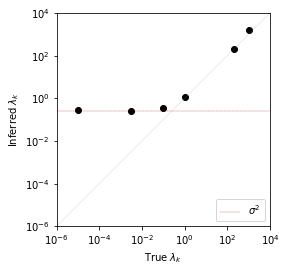

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(4, 4))

axes.scatter(lambdas_true, lambdas, c='black')
lims = (1e-6, 1e4)
axes.plot(lims, lims, c='grey', lw=0.3, alpha=0.5)
axes.plot(lims, (0.25, 0.25), c='darkred', lw=0.3, 
          label=r'$\sigma^2$', linestyle='--')
axes.set(xscale='log', yscale='log',
         xlabel=r'True $\lambda_k$',
         ylabel=r'Inferred $\lambda_k$',
         xlim=lims, ylim=lims,
         aspect=1)
axes.legend(loc=4)

fig.tight_layout()

### How to obtain phenotypic predictions

Once we know the parameters of the Variance Component kernel, this is, the variance components $\lambda_k$, we can directly compute the mean and variance of the posterior distribution of the function for every possible sequence

In [17]:
model.fit(X=obs.index.values, y=obs.y.values, y_var=obs.y_var.values)
pred = model.predict()
pred

,ypred
AAAAAA,-0.197050
AAAAAC,-1.667246
AAAAAG,-0.525272
AAAAAT,1.877927
AAAACA,0.967353
...,...
TTTTGT,2.400213
TTTTTA,-4.285704
TTTTTC,-1.509820
TTTTTG,-2.761167


We can now compare the predictions with the true function at sequences that were not observed and see how good we can predict missing sequences at random in this regime

In [18]:
test = data.loc[np.isnan(data['y']), :].copy()
test['pred'] = pred.loc[test.index, 'ypred'].values
r2 = pearsonr(test['pred'], test['y_true'])[0] ** 2

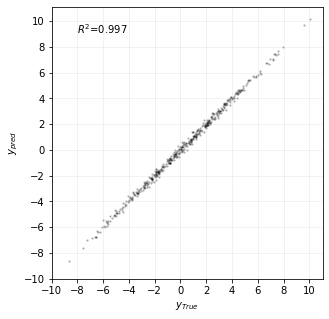

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))

axes.scatter(x=test.y_true, y=test.pred, c='black', alpha=0.2, s=2)
ticks = np.arange(-10, 11, 2)
axes.set(xlabel=r'$y_{True}$', ylabel=r'$y_{pred}$', aspect=1,
         xticks=ticks, yticks=ticks)
axes.text(-8, 9, r'$R^2$=' + '{:.3f}'.format(r2))
axes.grid(alpha=0.2)

## Inference from real data: GB1 landscape

### Data preprocessing

In [3]:
fpath = join('../data/GSE153897_Variant_frequency.csv')
data = pd.read_csv(fpath, index_col=0)
data.head()

,ParE3_rep1_t0,ParE2_rep1_t0,ParE3_rep2_t0,ParE2_rep2_t0,ParE3_rep1_t600,ParE2_rep1_t600,ParE3_rep2_t600,ParE2_rep2_t600
AAA,0.000091,0.000075,0.000086,0.000076,0.000110,0.000003,0.000100,4.850000e-06
AAC,0.000057,0.000065,0.000067,0.000068,0.000032,0.000001,0.000032,2.100000e-06
AAD,0.000049,0.000034,0.000041,0.000041,0.000025,0.000001,0.000019,6.470000e-07
AAE,0.000057,0.000052,0.000054,0.000049,0.000277,0.000002,0.000298,1.130000e-06
AAF,0.000133,0.000125,0.000133,0.000121,0.000158,0.000007,0.000151,7.760000e-06


In [4]:
data = data + data[data>0].min(0)

In [5]:
parE2_cols = ['ParE2_rep1', 'ParE2_rep2']
parE3_cols = ['ParE3_rep1', 'ParE3_rep2']
cols = parE2_cols + parE3_cols

logfitness = pd.DataFrame({col: np.log2(data['{}_t600'.format(col)] / data['{}_t0'.format(col)])
                           for col in cols}).dropna()

logfitness['parE2_mean'] = logfitness[parE2_cols].mean(1)
logfitness['parE2_var'] = logfitness[parE2_cols].var(1)
logfitness['parE3_mean'] = logfitness[parE3_cols].mean(1)
logfitness['parE3_var'] = logfitness[parE3_cols].var(1)

stops = np.array(['*' in x for x in logfitness.index])
stops_logf = logfitness.loc[stops, :]
logfitness = logfitness.loc[stops == False, :]

logfitness.head()

,ParE2_rep1,ParE2_rep2,ParE3_rep1,ParE3_rep2,parE2_mean,parE2_var,parE3_mean,parE3_var
AAA,-4.927789,-4.196607,0.058173,-0.031619,-4.562198,0.267314,0.013277,0.004031
AAC,-5.659228,-5.202646,-1.186775,-1.356459,-5.430937,0.104234,-1.271617,0.014396
AAD,-5.169573,-6.120851,-1.351620,-1.562352,-5.645212,0.452465,-1.456986,0.022204
AAE,-5.206682,-5.643856,1.936771,2.074769,-5.425269,0.095560,2.005770,0.009522
AAF,-4.317164,-4.109532,0.085886,0.017124,-4.213348,0.021555,0.051505,0.002364


In [13]:
d1 = logfitness[['parE2_mean', 'parE2_var']].copy()
d1.index = ['{}2'.format(x) for x in d1.index]
d1.columns = ['m','var']
d2 = logfitness[['parE3_mean', 'parE3_var']].copy()
d2.index = ['{}3'.format(x) for x in d2.index]
d2.columns = ['m','var']
data = pd.concat([d1, d2])
data


,m,var
AAA2,-4.562198,0.267314
AAC2,-5.430937,0.104234
AAD2,-5.645212,0.452465
AAE2,-5.425269,0.095560
AAF2,-4.213348,0.021555
...,...,...
YYS3,-4.336793,0.084424
YYT3,-3.480584,0.140443
YYV3,-2.161190,0.050462
YYW3,-3.625305,0.511585


### Run VC regression

In [16]:
vc = VCregression(cross_validation=True)
vc.fit(X=data.index, y=data.m.values, y_var=data['var'].values)
lambdas = vc.lambdas
pred = vc.predict(Xpred=data.index.values)  

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


In [35]:
x = np.arange(0, lambdas.shape[0])
variance = vc.lambdas_to_variance(lambdas)
p_variance = variance / variance.sum() * 100

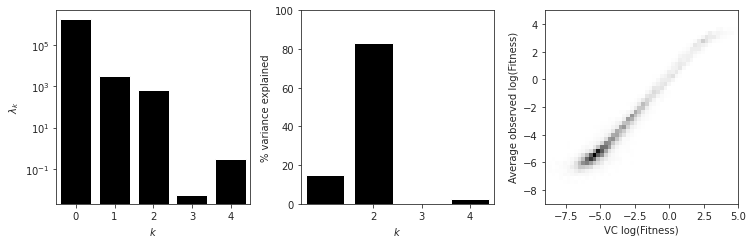

In [38]:
fig, subplots = plot.init_fig(1, 3, colsize=3.5, rowsize=3.5)

axes = subplots[0]
sns.barplot(x=x, y=lambdas, ax=axes, color='black')
axes.set(xlabel='$k$', ylabel='$\lambda_k$', yscale='log')

axes = subplots[1]
sns.barplot(x=x[1:], y=p_variance, ax=axes, color='black')
axes.set(xlabel='$k$', ylabel='% variance explained', ylim=(0, 100), xticks=[1, 2, 3])

axes = subplots[2]
sns.histplot(x=pred.loc[data.index, 'ypred'],
             y=data.m.values, cmap='Greys', ax=axes)
axes.set(xlabel='VC log(Fitness)', ylabel='Average observed log(Fitness)',
        xlim=(-9, 5), ylim=(-9, 5))
fig.tight_layout()